In [28]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.ops import nms
import matplotlib.pyplot as plt
import selectivesearch

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [30]:
image_dir = 'data/bus-trucks/images'

In [31]:

df = pd.read_csv('data/bus-trucks/df.csv')
# df.sample(5)

In [32]:
# Dataset class
class OpenImagesDataset(Dataset):
    def __init__(self, df, image_folder=image_dir):
        self.df = df
        self.image_folder = image_folder
        self.unique_images = df['ImageID'].unique()
    
    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self, idx):
        image_id = self.unique_images[idx]
        image_path = os.path.join(self.image_folder, f"{image_id}.jpg")
        image = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
        h, w, _ = image.shape

        annotations = self.df[self.df['ImageID'] == image_id]
        boxes = annotations[['XMin', 'YMin', 'XMax', 'YMax']].values
        boxes = (boxes * np.array([w, h, w, h])).astype(int).tolist()
        labels = annotations['LabelName'].tolist()

        return image, boxes, labels, image_path

In [33]:
dataset = OpenImagesDataset(df=df)

In [34]:
def show_image(image, bboxes=None, texts=None, confs=None):
    plt.imshow(image)
    ax = plt.gca()
    if bboxes:
        texts = texts or [""] * len(bboxes)
        confs = confs or [None] * len(bboxes)
        for bbox, text, conf in zip(bboxes, texts, confs):
            x1, y1, x2, y2 = bbox
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
            label = f"{text}" if conf is None else f"{text} ({conf:.2f})"
            if text:
                ax.text(x1, y1, label, bbox=dict(facecolor='yellow', alpha=0.5), fontsize=8, color='black')
    plt.axis('off')
    plt.show()

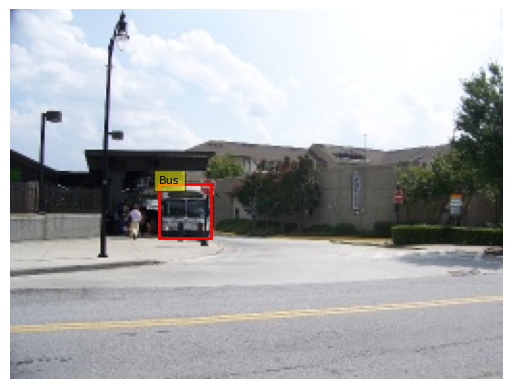

In [41]:
image, boxes, labels, _ = dataset[15]
show_image(image, boxes, labels)

In [42]:
# IoU calculation function
def compute_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = max(0, x2 - x1)
    height = max(0, y2 - y1)
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    return area_overlap / (area_combined + epsilon)

In [43]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    seen = set()
    for r in regions:
        x, y, w, h = r['rect']
        rect = (x, y, w, h)
        if r['size'] < 0.05 * img_area or r['size'] > img_area or rect in seen:
            continue
        seen.add(rect)
        candidates.append([x, y, x + w, y + h])
    return candidates

(22, 4)
<class 'list'>


/home/kazi/Works/Dtu/computer-vision/venv/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


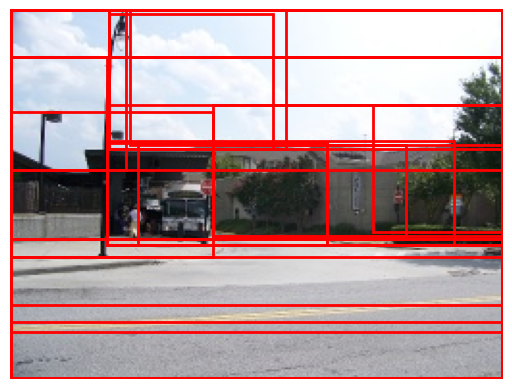

In [44]:
# Candidate extraction
candidates = extract_candidates(image)
print(np.shape(candidates))
print(type(candidates))
show_image(image, bboxes=candidates)

(192, 256, 3)
Best IoU: 0.05624999995814732


/home/kazi/Works/Dtu/computer-vision/venv/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


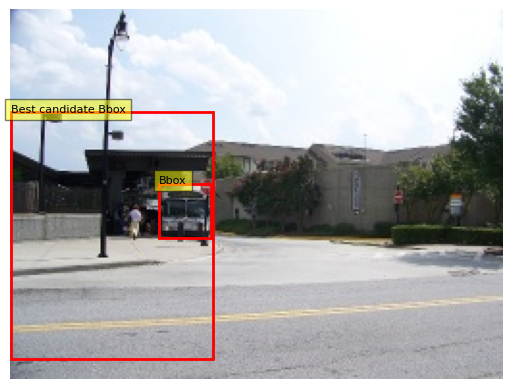

In [50]:
# IOU computation and region proposal processing
im, bbs, labels, fpath = dataset[15]
H, W, _ = im.shape
print(im.shape)
candidates = extract_candidates(im)
candidates = np.array([(x, y, x + w, y + h) for x, y, w, h in candidates])
# candidates
ious = np.array([[compute_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
# ious
best_ious = []
temp_best_bbs = []
rois, clss, deltas = [], [], []
for jx, candidate in enumerate(candidates):
    cx, cy, cX, cY = candidate

    candidate_ious = ious[jx]
    best_iou_at = np.argmax(candidate_ious)
    best_iou = candidate_ious[best_iou_at]
    best_ious.append(best_iou)
    best_bb = _x, _y, _X, _Y = bbs[best_iou_at]
    temp_best_bbs.append(best_bb)
    
    if best_iou > 0.3:
        clss.append(labels[best_iou_at])
    else:
        clss.append('background')
    
    delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
    deltas.append(delta)
    rois.append(candidate / np.array([W, H, W, H]))

best_ious_at = np.argmax(best_ious)
print("Best IoU:", best_ious[best_ious_at])

best_candidate = candidates[best_ious_at]
best_bbs = temp_best_bbs[best_ious_at]

show_image(im, bboxes=[best_bbs, best_candidate], texts=["Bbox", "Best candidate Bbox"])

In [51]:
# Initialize lists to store results for all images
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500  # Limit the processing to 500 images

In [ ]:
for ix , (im, bbs, labels, fpath) in enumerate(dataset):
    
    if ix == N: # Stop after processing N images
        break

    # Get image dimensions
    H, W, _ = im.shape

    # Generate region proposals (candidates) and convert to bounding box format
    candidates = extract_candidates(im)
    candidates = np.array([(x, y, x + w, y + h) for x, y, w, h in candidates])

     # Initialize lists for this image
    ious, rois, clss, deltas = [], [], [], []

    # Compute IoU between candidates and ground-truth boxes
    ious = np.array([[compute_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T

     # Process each candidate region
    for jx, candidate in enumerate(candidates):
        cx, cy, cX, cY = candidate  # Coordinates of the candidate
        candidate_ious = ious[jx]  # IoUs with all ground-truth boxes
        best_iou_at = np.argmax(candidate_ious)  # Ground-truth box with highest IoU
        best_iou = candidate_ious[best_iou_at]  # Highest IoU value

        best_bb = _x, _y, _X, _Y = bbs[best_iou_at]  # Best matching ground-truth box

        # Classify the candidate region
        if best_iou > 0.3:  # Significant overlap
            clss.append(labels[best_iou_at])  # Assign the corresponding class label
        else:
            clss.append('background')  # Otherwise, classify as "background"

         # Compute deltas (offsets) for bounding box refinement
        delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
        deltas.append(delta)
        # Normalize the candidate region
        rois.append(candidate / np.array([W, H, W, H]))

    # Append results for this image
    FPATHS.append(fpath)  # File path of the image
    IOUS.append(ious)  # IoU matrix for this image
    ROIS.append(rois)  # Normalized candidate regions
    CLSS.append(clss)  # Class labels for candidates
    DELTAS.append(deltas)  # Bounding box deltas
    GTBBS.append(bbs)  # Ground-truth bounding boxes

# Process file paths to include the image directory
FPATHS = [f'{image_dir}/{os.path.basename(f)}' for f in FPATHS]
# print(FPATHS)

/home/kazi/Works/Dtu/computer-vision/venv/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/kazi/Works/Dtu/computer-vision/venv/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/kazi/Works/Dtu/computer-vision/venv/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommend

['data/bus-trucks/images/0000599864fd15b3.jpg', 'data/bus-trucks/images/00006bdb1eb5cd74.jpg', 'data/bus-trucks/images/00010bf498b64bab.jpg', 'data/bus-trucks/images/00013f14dd4e168f.jpg', 'data/bus-trucks/images/0002914fa805e227.jpg', 'data/bus-trucks/images/00036603fa39fa85.jpg', 'data/bus-trucks/images/0004d5a9dd44ab6a.jpg', 'data/bus-trucks/images/0005f203463a13a8.jpg', 'data/bus-trucks/images/00066517f9d814f9.jpg', 'data/bus-trucks/images/00072b81abc72d21.jpg', 'data/bus-trucks/images/000780f791b71252.jpg', 'data/bus-trucks/images/0007eeeabf3c5e5c.jpg', 'data/bus-trucks/images/000812dcf304a8e7.jpg', 'data/bus-trucks/images/000817a6f6819e73.jpg', 'data/bus-trucks/images/000924a411c24d25.jpg', 'data/bus-trucks/images/0009b74be294a699.jpg', 'data/bus-trucks/images/0009da46ef64adb7.jpg', 'data/bus-trucks/images/0009ebddec6542a5.jpg', 'data/bus-trucks/images/000d2e3d33b18463.jpg', 'data/bus-trucks/images/000e83dc68db5ca8.jpg', 'data/bus-trucks/images/001017b68b67625c.jpg', 'data/bus-tr

/home/kazi/Works/Dtu/computer-vision/venv/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [57]:
# print(CLSS)
# Flatten results into a DataFrame for labels
targets = pd.DataFrame([label for labels in CLSS for label in labels], columns=['label'])
print((targets))

# Map labels to numeric targets
label2target = {label: idx for idx, label in enumerate(targets['label'].unique())}
target2label = {idx: label for label, idx in label2target.items()}
background_class = label2target['background']  # Class ID for "background"

# Print the label-to-target mapping
print("The label-to-target values dictionary formed is:", label2target)

            label
0      background
1             Bus
2      background
3             Bus
4      background
...           ...
11633  background
11634       Truck
11635       Truck
11636       Truck
11637       Truck

[11638 rows x 1 columns]
The label-to-target values dictionary formed is: {'background': 0, 'Bus': 1, 'Truck': 2}


In [58]:
# Normalizing the image using the mean and standard deviation used during model training
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [59]:
# Preprocessing function for images
def preprocess_image(img):
    img = torch.tensor(img).permute(2, 0, 1)  # Convert (H, W, C) to (C, H, W)
    img = normalize(img)  # Apply normalization
    return img.to(device).float()  # Convert to float and move to the specified device (CPU/GPU)

In [60]:
# Function to decode predictions (from logits to class labels)
def decode(predictions):
    _, preds = predictions.max(-1)  # Get the index of the max logit for each prediction
    return preds

In [61]:
# Dataset class for RCNN
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        """
        Args:
            fpaths: List of file paths for the images.
            rois: List of region proposals (candidate bounding boxes).
            labels: Class labels corresponding to each ROI.
            deltas: Bounding box adjustments for refining proposals.
            gtbbs: Ground truth bounding boxes for each image.
        """
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self):
        """Returns the total number of samples."""
        return len(self.fpaths)
    
    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.
        Returns:
            image: Original image.
            crops: Cropped regions based on bounding boxes.
            bbs: Rescaled bounding boxes in absolute pixel coordinates.
            labels: Class labels for the regions.
            deltas: Bounding box adjustments.
            gtbbs: Ground truth bounding boxes.
            fpath: File path for the image.
        """
        fpath = str(self.fpaths[idx])
        image = cv2.imread(fpath, 1)[..., ::-1]  # Load image and convert BGR to RGB

        H, W, _ = image.shape
        scale = np.array([W, H, W, H])  # Scale factors for width and height
        gtbbs = self.gtbbs[idx]
        rois = self.rois[idx]
        bbs = (np.array(rois) * scale).astype(np.uint16)  # Scale ROIs to pixel coordinates
        labels = self.labels[idx]
        deltas = self.deltas[idx]
        crops = [image[y:Y, x:X] for (x, y, X, Y) in bbs]  # Crop image regions
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    
    def collate_fn(self, batch):
        """
        Custom collate function to process batches of data.
        Args:
            batch: List of samples from __getitem__.

        Returns:
            input: Tensor of cropped image regions (for classification and regression).
            labels: Tensor of class labels.
            deltas: Tensor of bounding box adjustments.
        """
        inputs, labels, deltas = [], [], []
        for sample in batch:
            image, crops, bbs, image_labels, image_deltas, _, _ = sample
            # Resize crops to a fixed size (224x224) and normalize
            crops = [cv2.resize(crop, (224, 224)) for crop in crops]
            crops = [preprocess_image(crop / 255.0)[None] for crop in crops]
            inputs.extend(crops)
            labels.extend([label2target[label] for label in image_labels])  # Convert labels to numeric
            deltas.extend(image_deltas)
        inputs = torch.cat(inputs).to(device)  # Concatenate and move to device
        labels = torch.tensor(labels).long().to(device)
        deltas = torch.tensor(deltas).float().to(device)
        return inputs, labels, deltas

In [62]:
# Split data into train and test datasets
n_train = 9 * len(FPATHS) // 10  # 90% of data for training
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

# Create DataLoaders for batching
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

# Load a pretrained VGG16 model
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()  # Remove the fully connected layers

# Freeze the backbone weights
for param in vgg_backbone.parameters():
    param.requires_grad = False

# Set the backbone to evaluation mode
vgg_backbone.eval().to(device)

/home/kazi/Works/Dtu/computer-vision/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kazi/Works/Dtu/computer-vision/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [63]:
class RCNN(nn.Module):

    def __init__(self):
        super().__init__()
        # Feature dimension from the VGG16 backbone
        feature_dim = 25088
        
        # Backbone for feature extraction (pretrained VGG16)
        self.backbone = vgg_backbone

         # Fully connected layer for classification (number of classes = len(label2target))
        self.cls_score = nn.Linear(feature_dim, len(label2target))

       # Fully connected layers for bounding box regression
        self.bbox = nn.Sequential(
            nn.Linear(feature_dim, 512),  # Reduce dimensionality
            nn.ReLU(),                   # Activation function
            nn.Linear(512, 4),           # Output 4 coordinates for the bounding box
            nn.Tanh()                    # Normalize bounding box deltas
        )

         # Loss functions
        self.cel = nn.CrossEntropyLoss()  # Classification loss
        self.sl1 = nn.L1Loss()           # Regression loss (Smooth L1 Loss is another alternative)

    def forward(self, x):
        """
        Forward pass of the model.
        Args:
            x: Input tensor (batch of cropped image regions).
        Returns:
            cls_score: Predicted class scores for each input.
            bbox: Predicted bounding box adjustments (deltas).
        """
         
        # Extract features using the backbone
        features = self.backbone(x)
        # Predict class scores
        cls_score = self.cls_score(features)
        # Predict bounding box adjustments
        bbox = self.bbox(features)
        return cls_score, bbox
    
    def calc_loss(self, probs, _deltas, labels, deltas):
        """
        Calculate the total loss for the model (classification + regression).
        Args:
            probs: Predicted class probabilities.
            _deltas: Predicted bounding box deltas.
            labels: Ground truth class labels.
            deltas: Ground truth bounding box deltas.
        Returns:
            total_loss: Combined classification and regression loss.
            detection_loss: Classification loss (detached for monitoring).
            regression_loss: Regression loss (detached for monitoring).
        """
        # Classification loss (cross-entropy)
        detection_loss = self.cel(probs, labels)

        # Select only the indices where the label is NOT background (label 1)
        ixs, = torch.where(labels != 1)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]

        # Regression loss (only computed for non-background regions)
        self.lmb = 10.0  # Weight for regression loss
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            total_loss = detection_loss + self.lmb * regression_loss
        else:
            # If all samples are background, only use classification loss
            regression_loss = 0
            total_loss = detection_loss

        # Return total loss and individual losses (detached for logging purposes)
        return total_loss, detection_loss.detach(), regression_loss.detach()


In [64]:
def train_batch(batch_data, model, optimizer, criterion):
    """
    Performs a single training step on a batch of data.
    
    Args:
        batch_data: Tuple containing (inputs, class labels, bounding box deltas)
            - inputs: Tensor of cropped image regions.
            - clss: Ground-truth class labels for each region.
            - deltas: Ground-truth bounding box offsets (deltas).
        model: The RCNN model being trained.
        optimizer: Optimizer used to update model parameters (e.g., SGD, Adam).
        criterion: Function to calculate the total loss (classification + regression).
        
    Returns:
        loss.detach(): Total loss (detached for monitoring).
        loc_loss: Classification loss.
        regr_loss: Regression loss.
        accs.cpu().numpy(): Classification accuracy as a NumPy array.
    """
    
    # Unpack the batch data into individual components
    inputs, clss, deltas = batch_data

    # Set the model to training mode
    model.train()

    # Clear any previously computed gradients
    optimizer.zero_grad()

    # Forward pass: Get predictions from the model
    predicted_classes, predicted_deltas = model(inputs)

    # Compute the total loss (classification + regression)
    total_loss, loc_loss, regr_loss = criterion(predicted_classes, predicted_deltas, clss, deltas)

    # Calculate classification accuracy
    # `decode` converts predicted logits into class labels, and comparison with ground-truth (`clss`) gives accuracy
    accs = clss == decode(predicted_classes)

    # Backpropagate the loss to compute gradients
    total_loss.backward()

    # Update model parameters using the optimizer
    optimizer.step()

    # Detach the loss values and return them along with accuracy
    return total_loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()


In [65]:
@torch.no_grad()  # Disable gradient calculation to save memory and computation
def validate_batch(batch_data, model, criterion):
    """
    Validates a single batch of data during evaluation.
    
    Args:
        batch_data: Tuple containing (inputs, class labels, bounding box deltas)
            - inputs: Tensor of cropped image regions.
            - clss: Ground-truth class labels for each region.
            - deltas: Ground-truth bounding box offsets (deltas).
        model: The RCNN model being evaluated.
        criterion: Function to calculate the total loss (classification + regression).
    
    Returns:
        predicted_classes: Predicted class labels.
        predicted_deltas: Predicted bounding box adjustments (deltas).
        total_loss: Combined classification and regression loss.
        loc_loss: Classification loss.
        regr_loss: Regression loss.
        accs.cpu().numpy(): Classification accuracy as a NumPy array.
    """
    # Unpack the batch data into individual components
    inputs, clss, deltas = batch_data

    # Set the model to evaluation mode
    model.eval()

    # Forward pass: Get predictions from the model
    predicted_classes, predicted_deltas = model(inputs)

    # Compute the total loss (classification + regression)
    total_loss, loc_loss, regr_loss = criterion(predicted_classes, predicted_deltas, clss, deltas)

    # Decode class logits to get predicted labels
    _, predicted_classes = predicted_classes.max(-1)  # Get the index of the highest probability class

    # Calculate classification accuracy
    accs = clss == predicted_classes

    # Return the predictions, losses, and accuracy
    return (
        predicted_classes,               # Predicted class labels
        predicted_deltas,                # Predicted bounding box adjustments
        total_loss.detach(),             # Total loss
        loc_loss,                        # Classification loss
        regr_loss,                       # Regression loss
        accs.cpu().numpy()               # Accuracy as a NumPy array
    )


/tmp/ipykernel_81120/196481193.py:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  deltas = torch.tensor(deltas).float().to(device)


Epoch 1/5:
  Train Loss: 2.8691, Train Accuracy: 78.72%
  Val Loss:   2.6143, Val Accuracy:   78.42%
Epoch 2/5:
  Train Loss: 1.8846, Train Accuracy: 89.49%
  Val Loss:   2.4144, Val Accuracy:   79.67%
Epoch 3/5:
  Train Loss: 1.4534, Train Accuracy: 93.19%
  Val Loss:   2.3860, Val Accuracy:   80.51%
Epoch 4/5:
  Train Loss: 1.2169, Train Accuracy: 95.08%
  Val Loss:   2.4223, Val Accuracy:   80.59%
Epoch 5/5:
  Train Loss: 1.0709, Train Accuracy: 96.31%
  Val Loss:   2.3856, Val Accuracy:   80.99%


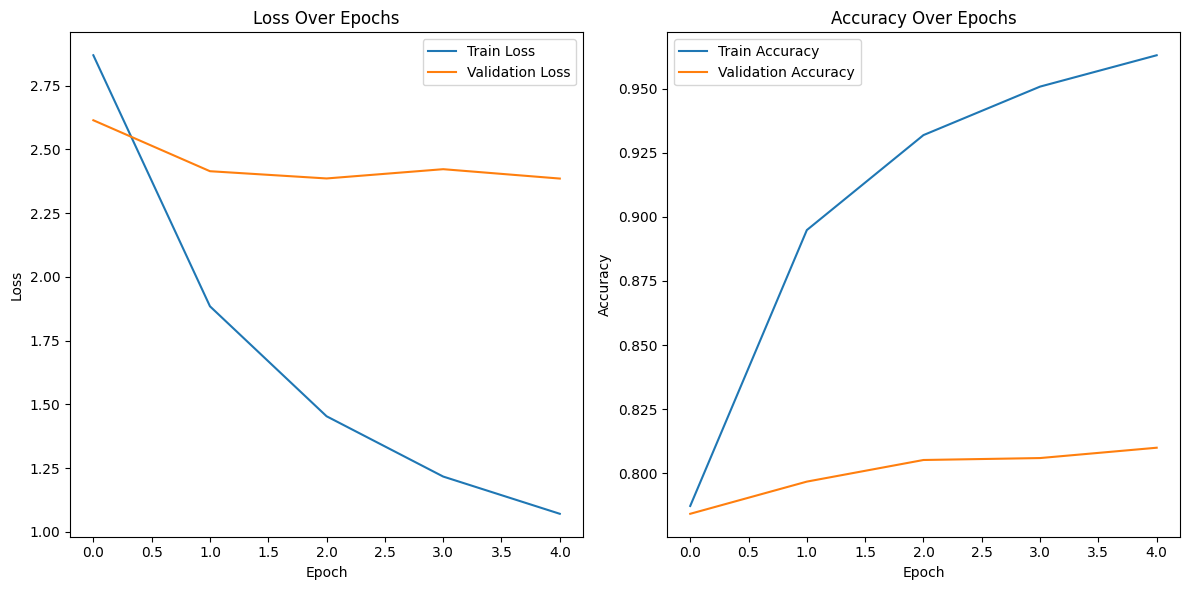

In [ ]:
# Initialize RCNN model, loss function, and optimizer
rcnn = RCNN().to(device)  # Move RCNN model to the appropriate device (CPU/GPU)
criterion = rcnn.calc_loss  # Use the `calc_loss` method from the RCNN model
optimizer = torch.optim.SGD(rcnn.parameters(), lr=1e-3)  # Use SGD optimizer with a learning rate of 1e-3

# Training configuration
n_epochs = 5  # Number of epochs

# Initialize lists to log metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(n_epochs):
    # Initialize epoch metrics
    epoch_train_loss, epoch_train_acc = 0, 0
    epoch_val_loss, epoch_val_acc = 0, 0
    
    # Training phase
    rcnn.train()

    for batch_idx, inputs in enumerate(train_loader):
         # Train the model on a single batch
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, optimizer, criterion)
        
         # Accumulate metrics
        epoch_train_loss += loss.item()
        epoch_train_acc += accs.mean()
    
    # Average training metrics
    train_losses.append(epoch_train_loss / len(train_loader))
    train_accuracies.append(epoch_train_acc / len(train_loader))

    # Validation phase
    rcnn.eval()
    with torch.no_grad():
        for batch_idx, inputs in enumerate(test_loader):
            # Validate the model on a single batch
            pred_classes, pred_deltas, loss, loc_loss, regr_loss, accs = validate_batch(inputs, rcnn, criterion)
            
            # Accumulate metrics
            epoch_val_loss += loss.item()
            epoch_val_acc += accs.mean()
    
     # Average validation metrics
    val_losses.append(epoch_val_loss / len(test_loader))
    val_accuracies.append(epoch_val_acc / len(test_loader))

    # Print epoch summary
    print(f"Epoch {epoch+1}/{n_epochs}:")
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2%}")
    print(f"Val Loss:   {val_losses[-1]:.4f}, Val Accuracy:   {val_accuracies[-1]:.2%}")

# Plotting results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [79]:
import cv2
import numpy as np
import torch
from torchvision.ops import nms
import matplotlib.pyplot as plt

def test_predictions(filename, show_output=True):
    """
    Perform object detection on an image using RCNN and Non-Max Suppression (NMS).

    Args:
        filename: Path to the input image file.
        show_output: Boolean flag to display the image and predictions.

    Returns:
        Tuple:
        - Best bounding box (x, y, X, Y).
        - Predicted label for the detected object.
        - Confidence score of the best prediction.
    """
    # Load and preprocess the image
    img = cv2.imread(filename)[..., ::-1]  # Convert BGR to RGB
    candidates = extract_candidates(img)  # Generate region proposals

    if not candidates:  # Handle case of no candidates
        if show_output:
            print("No candidates generated.")
        return (0, 0, 224, 224), 'background', 0

    candidates = [(x, y, x + w, y + h) for x, y, w, h in candidates]  # Convert to (x1, y1, x2, y2)

    # Prepare inputs for RCNN
    input_tensors = []
    for x, y, X, Y in candidates:
        crop = cv2.resize(img[y:Y, x:X], (224, 224))  # Resize region to 224x224
        input_tensors.append(preprocess_image(crop / 255.0)[None])  # Normalize and convert to tensor

    # Combine inputs into a single tensor
    inputs = torch.cat(input_tensors).to(device)

    # Perform inference using the RCNN model
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(inputs)
        probs = torch.nn.functional.softmax(probs, dim=-1)  # Convert logits to probabilities
        confs, clss = torch.max(probs, dim=-1)  # Get confidence scores and class IDs

    # Convert tensors to numpy arrays
    candidates = np.array(candidates)
    confs, clss, deltas = [t.detach().cpu().numpy() for t in [confs, clss, deltas]]

    # Filter out predictions classified as "background"
    valid_indices = clss != background_class
    if not valid_indices.any():  # Handle case of no valid predictions
        if show_output:
            print("No valid predictions.")
        return (0, 0, 224, 224), 'background', 0

    confs, clss, deltas, candidates = [
        arr[valid_indices] for arr in [confs, clss, deltas, candidates]
    ]

    # Adjust bounding boxes using the predicted deltas
    bbs = (candidates + deltas).astype(np.uint16)

    # Apply Non-Max Suppression (NMS)
    indices = nms(torch.tensor(bbs, dtype=torch.float32), torch.tensor(confs), iou_threshold=0.05)
    bbs, confs, clss = [np.array(arr)[indices.cpu().numpy()] for arr in [bbs, confs, clss]]

    # Handle case of no bounding boxes remaining after NMS
    if len(indices) == 0:
        if show_output:
            print("No bounding boxes remain after NMS.")
        return (0, 0, 224, 224), 'background', 0

    # Identify the best prediction
    best_index = np.argmax(confs)
    best_bb = bbs[best_index]
    best_label = target2label[int(clss[best_index])]  # Ensure correct indexing
    best_conf = confs[best_index]

    # Visualize results if show_output is True
    if show_output:
        visualize_predictions(img, bbs, clss, target2label, best_bb, best_label)

    return tuple(best_bb), best_label, best_conf

def visualize_predictions(img, bbs, clss, target2label, best_bb=None, best_label=None):
    """
    Display the image with predicted bounding boxes and labels.

    Args:
        img: The original image.
        bbs: List of bounding boxes.
        clss: List of predicted class IDs.
        target2label: Mapping of class IDs to class labels.
        best_bb: Best bounding box (optional).
        best_label: Label of the best bounding box (optional).
    """
    _, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Original image
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Predictions
    ax[1].imshow(img)
    for bb, label in zip(bbs, clss):
        x, y, X, Y = bb
        ax[1].add_patch(
            plt.Rectangle((x, y), X - x, Y - y, fill=False, edgecolor='red', linewidth=2)
        )
        ax[1].text(
            x, y, target2label[int(label)], color="yellow", fontsize=8,
            bbox=dict(facecolor='black', alpha=0.5)
        )

    # Set title for the best prediction if available
    if best_bb is not None and best_label is not None:
        ax[1].set_title(f"Best Prediction: {best_label}")
    else:
        ax[1].set_title("Predictions")

    ax[1].axis("off")
    plt.show()

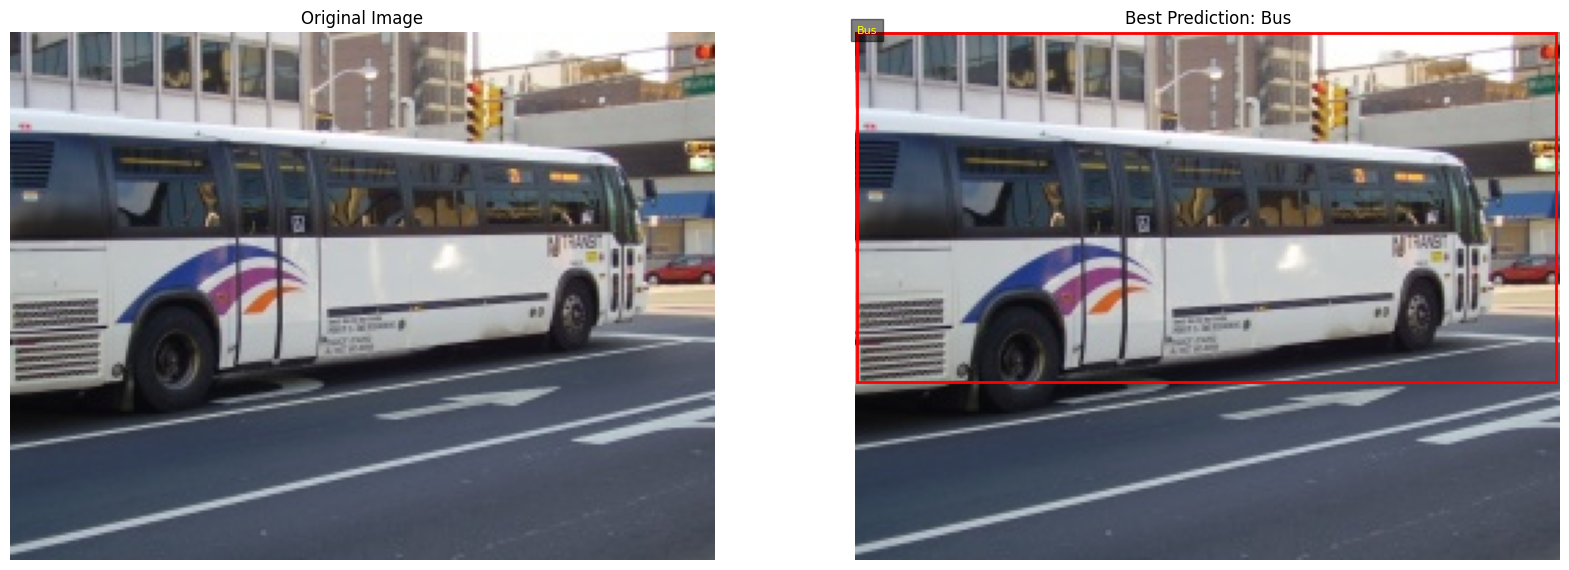

Best Bounding Box: (0, 0, 254, 127), Label: Bus, Confidence: 1.00


In [82]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[2]
best_bb, best_label, best_conf = test_predictions(fpath)
print(f"Best Bounding Box: {best_bb}, Label: {best_label}, Confidence: {best_conf:.2f}")